# Relative ROGI plots

In [1]:
from pathlib import Path
from typing import Iterable, Union

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

rc = mpl.rc_params_from_file(mpl.matplotlib_fname(), use_default_template=False)
sns.set_theme(style="white", rc=rc)

REPR_LABELS = dict(
    fp="FP", vae="VAE", gin="GIN", chemberta="ChemBERTa", chemgpt="ChemGPT", descriptor='descriptors'
)
JITTER = 0.1625
CSV_DIR = Path("../results/raw/rogi/tdc+guac")

In [3]:
def disable_gridlines(ax: plt.Axes, axis: str, vals: Union[float, Iterable[float]]):
    if isinstance(vals, float):
        vals = [vals]
    vals = set(vals)

    gridlines = ax.get_xgridlines() if axis == "x" else ax.get_ygridlines()
    for line in gridlines:
        v = line.get_xdata()[0] if axis == "x" else line.get_ydata()[0]
        if v in vals:
            line.set(visible=False)
    
    return ax


def rogi_string(x: str):
    return rf"$\mathrm{{ROGI-XD}}_{{\mathrm{{{x}}}}}$"

In [4]:
df = pd.concat([pd.read_csv(p) for p in CSV_DIR.iterdir() if not p.is_dir()], ignore_index=True)\
    .rename(columns={'dataset_and_task': "task"})\
    .groupby(["representation", "task"])\
    .mean()\
    .reset_index()\
    .replace({"morgan": "FP", "descriptor": "descriptors"})

REPRS = ["chemberta", "chemgpt", "gin", "vae", "descriptors", "FP"]
PRETRAINED_REPRS = ["chemberta", "chemgpt", "gin", "vae"]

sns.set_palette("Set2", len(REPRS))
COLORS = sns.color_palette("Set2", len(REPRS))
REPR_COLORS = dict(zip(REPRS, COLORS))

df

,representation,task,rogi,n_valid
0,chemberta,ARIPIPRAZOLE_SIMILARITY,0.158179,10000.0
1,chemberta,CACO2_WANG,0.217590,910.0
2,chemberta,CELECOXIB_REDISCOVERY,0.156523,10000.0
3,chemberta,CLEARANCE_HEPATOCYTE_AZ,0.446076,1213.0
4,chemberta,CLEARANCE_MICROSOME_AZ,0.369319,1102.0
...,...,...,...,...
97,vae,PPBR_AZ,0.213338,1614.0
98,vae,SCAFFOLD HOP,0.114157,10000.0
99,vae,SOLUBILITY_AQSOLDB,0.143722,9982.0
100,vae,VDSS_LOMBARDO,0.049239,1130.0


In [5]:
df_desc = df.query(f"representation == 'descriptors'").set_index("task")
df_fp = df.query(f"representation == 'FP'").set_index("task")
df_pcms = [df.query(f"representation == '{f}'").set_index('task') for f in PRETRAINED_REPRS]

for df_ in df_pcms:
    df_["rogi_desc"] = df_['rogi'] / df_desc['rogi'] - 1
    df_["rogi_fp"] = df_['rogi'] / df_fp['rogi'] - 1

df_rel = pd.concat(df_pcms).reset_index()

In [6]:
x = df.groupby("representation").rogi.apply(np.array)['descriptors']
x.min(), x.max()

(0.0465630806273556, 0.4401489869004399)

In [7]:
s = df.groupby("representation").rogi.apply(np.sort)
X = np.array([s[r] for r in REPRS])
X

array([[0.04160378, 0.09054517, 0.09799598, 0.10680955, 0.11678901,
        0.13587353, 0.15495535, 0.1565227 , 0.15817872, 0.16807419,
        0.1723378 , 0.21759034, 0.24683524, 0.26217968, 0.29347398,
        0.36931863, 0.44607585],
       [0.05208586, 0.08959611, 0.10323407, 0.11002378, 0.1248786 ,
        0.14928657, 0.15295035, 0.15589592, 0.15877354, 0.16052551,
        0.17361178, 0.19299871, 0.22576629, 0.26885199, 0.28226426,
        0.41757403, 0.43932857],
       [0.05080547, 0.09418671, 0.09990777, 0.10658723, 0.10862576,
        0.11440311, 0.12674707, 0.12987986, 0.13481967, 0.14991195,
        0.1619799 , 0.18260657, 0.21483148, 0.24735023, 0.26232079,
        0.40002335, 0.43536176],
       [0.04923855, 0.09725305, 0.09863696, 0.10381027, 0.10748776,
        0.1102204 , 0.11414219, 0.11415692, 0.13209473, 0.14372208,
        0.16521254, 0.19640767, 0.21333778, 0.25450324, 0.25578156,
        0.39015835, 0.44436971],
       [0.04656308, 0.05760821, 0.07911512, 0.084901

## Relative ROGI distribution boxplot

In [8]:
def add_boxplot(df: pd.DataFrame, x_key: str = "descriptor", ax = None):
    ax = ax or plt.gca()
    
    s_rogis = df.groupby("representation").rogi.apply(np.array)
    x = s_rogis[x_key]
    ys = [s_rogis[f] for f in PRETRAINED_REPRS]

    Z = np.array(ys) / x - 1
    Z *= 100

    bplot = ax.boxplot(
        Z.T,
        vert=False,
        labels=[REPR_LABELS.get(f, f) for f in PRETRAINED_REPRS],
        widths=4 * JITTER,
        showmeans=True,
        patch_artist=True,
        boxprops=dict(fc="None"),
        medianprops=dict(c=None),
        meanprops=dict(ms=8),
        showfliers=False,
    )

    for l, r in zip(bplot['medians'], PRETRAINED_REPRS):
        l.set_color(REPR_COLORS[r])

    ax.grid(which="both", axis="x", ls="--", dashes=(4, 4))

    for j, r in zip(range(len(Z)), PRETRAINED_REPRS):
        z = Z[j]
        y = (j + 1) + np.random.uniform(-JITTER, JITTER, z.shape)

        ax.plot(z, y, 'o', color=REPR_COLORS[r])

    ax.grid(False, axis='both')

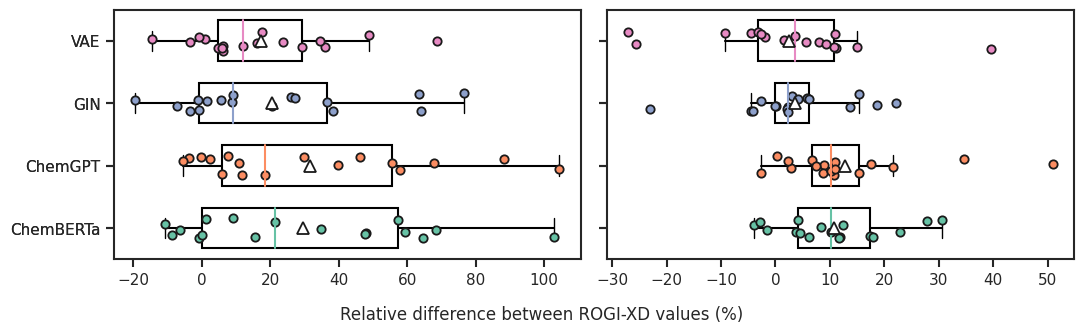

In [9]:
sns.set_palette("Set2")

fig, axs = plt.subplots(1, 2, figsize=(1 + 2 * 5, 3.5), sharey=True)

add_boxplot(df, "descriptors", axs[0])
add_boxplot(df, "FP", axs[1])

fig.supxlabel("Relative difference between ROGI-XD values (%)", fontsize="medium", y=0.05)
fig.tight_layout()

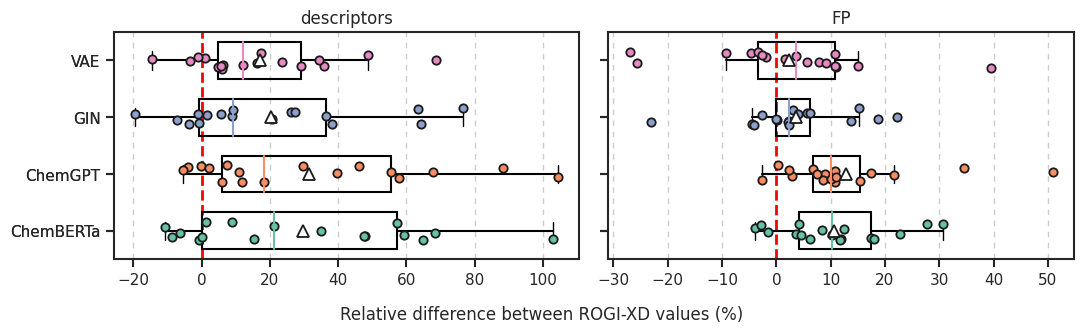

In [10]:
for ax, l in zip(axs, ["descriptors", "FP"]):
    ax.grid(True, axis='x')
    disable_gridlines(ax, "x", [0.])
    ax.axvline(0, ls="--", color="red", zorder=0, alpha=1)
    ax.set_title(l, fontsize="medium")
    
fig.tight_layout()
fig

In [11]:
fig.savefig("../results/figures/boxplot-both-v2.pdf", bbox_inches="tight")

## ROGI distribution

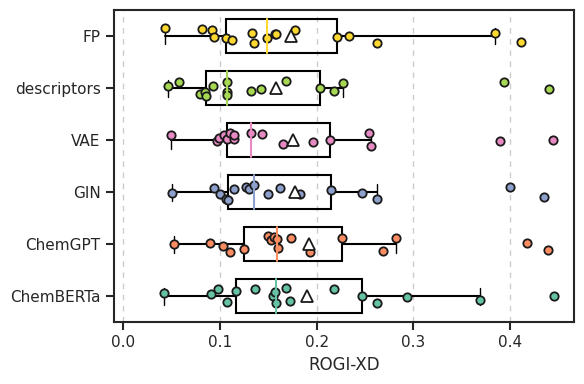

In [13]:
JITTER = 0.1625
COLORS = sns.color_palette(None, len(REPRS))

fig, ax = plt.subplots(figsize=(6, 4))

s = df.groupby("representation").rogi.apply(np.sort)
X = np.array([s[r] for r in REPRS])

bplot = ax.boxplot(
    X.T,
    vert=False,
    labels=[REPR_LABELS.get(r, r) for r in REPRS],
    widths=4 * JITTER,
    showmeans=True,
    patch_artist=True,
    boxprops=dict(fc="None"),
    medianprops=dict(c=None),
    meanprops=dict(ms=8),
    showfliers=False,
)

for l, r in zip(bplot['medians'], REPRS):
    l.set_color(REPR_COLORS[r])
    

for j, r in zip(range(len(X)), REPRS):
    z = X[j]
    y = (j + 1) + np.random.uniform(-JITTER, JITTER, z.shape)

    ax.plot(z, y, 'o', color=REPR_COLORS[r])

ax.set_xlim(-0.01)
ax.grid(which="both", axis="x", ls="--", dashes=(4, 4))
ax.grid(False, 'major', 'y')
ax.set_xlabel("ROGI-XD")

fig.tight_layout()

In [14]:
fig.savefig("../results/figures/rogi-dist.pdf", bbox_inches="tight")

In [352]:
s.apply(min), s.apply(max)

(representation
 FP             0.042820
 chemberta      0.041604
 chemgpt        0.052086
 descriptors    0.046563
 gin            0.050805
 vae            0.049239
 Name: rogi, dtype: float64,
 representation
 FP             0.411782
 chemberta      0.446076
 chemgpt        0.439329
 descriptors    0.440149
 gin            0.435362
 vae            0.444370
 Name: rogi, dtype: float64)

In [71]:
df.query('task == "SCAFFOLD HOP"')

,representation,dataset,rogi,n_valid
14,chemberta,SCAFFOLD HOP,0.172338,10000.0
32,chemgpt,SCAFFOLD HOP,0.173612,10000.0
50,descriptor,SCAFFOLD HOP,0.084902,10000.0
68,gin,SCAFFOLD HOP,0.149912,10000.0
86,morgan,SCAFFOLD HOP,0.156436,10000.0
104,vae,SCAFFOLD HOP,0.117476,10000.0
